**Dependencies**

In [1]:
import sys
from obspy import UTCDateTime
from DataDownload import *
from DataProcessing import *
from EventIdentification import *
from CataloguedEvents import *
from utils import *


**Set Date And Station**

In [2]:
date = UTCDateTime("2024-04-23") 

# station = ['GB', 'EDMD', 'IRIS']
station = ['AM','R50D6','https://data.raspberryshake.org']

# get the coordination for the station
station_coordinates = get_coordinates(station)

# Try to download data and return availability for the date
data_available = download_seismic_data(date, station)

Data for 2024-04-23 already downloaded.


**Original Stream**

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-22T23:00:00.004000Z - 2024-04-24T01:00:00.004000Z | 100.0 Hz, 9360001 samples


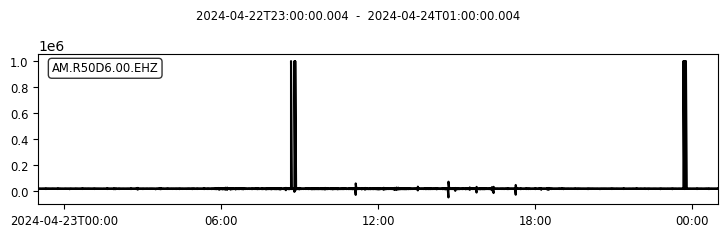

TypeError: 'Figure' object is not subscriptable

In [3]:
# Get stream from mseed file using date and st
stream = get_stream(date, station)
print(stream)

# Before processing
stream.plot()[0]

**Processed Stream**

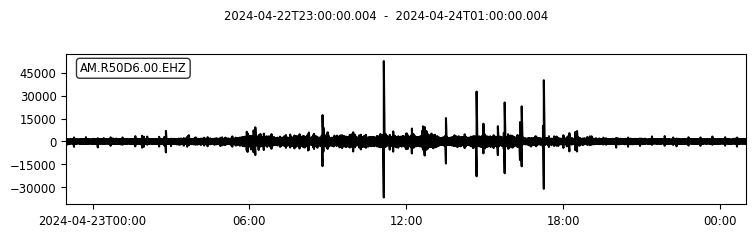

TypeError: 'Figure' object is not subscriptable

In [4]:
processed_stream = stream_process(stream)
processed_stream.plot()[0]

**Find Earthquake From Catalogue**

Number of Identified Earthquakes: 5
5 Event(s) in Catalog:
2024-04-23T15:40:05.079000Z | +38.158,  -30.835 | 5.2  Mww
2024-04-23T13:05:39.336000Z | +50.100,  -28.970 | 5.0  mww
2024-04-23T02:21:00.008000Z | +23.833, +121.610 | 5.2  Mwr
2024-04-23T00:11:02.661000Z | +23.898, +121.598 | 5.2  mb
2024-04-23T00:04:05.608000Z | +23.803, +121.676 | 5.8  mww


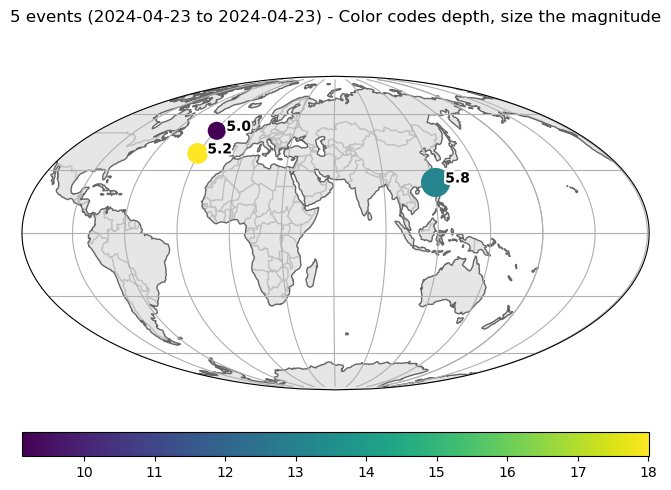

TypeError: 'Figure' object is not subscriptable

In [5]:
catalog = find_earthquakes(
    fromwhere='IRIS',
    latitude=station_coordinates[0],
    longitude=station_coordinates[1],
    date = date,
    radmin=0,
    radmax=90,
    minmag=5,
    maxmag=10
)

print('Number of Identified Earthquakes:', len(catalog))
print(catalog) 
catalog.plot()[0]  # Plotting the catalog

**Create a DataFrame for Events with Predicted Arrival Times**

In [6]:
df = predict_arrivals(catalog, station_coordinates)
df

,time,lat,long,mag,mag_type,P_arrival,S_arrival,catalogued,detected
0,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.306903,2024-04-23T15:50:13.431885,True,False
1,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.627392,2024-04-23T13:13:20.674606,True,False
2,2024-04-23T02:21:00.008000,23.8333,121.6102,5.2,Mwr,2024-04-23T02:33:48.823173,2024-04-23T02:44:31.345600,True,False
3,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,2024-04-23T00:23:50.629125,2024-04-23T00:34:32.470403,True,False
4,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,2024-04-23T00:16:54.171368,2024-04-23T00:27:36.589723,True,False


**Produce Stream Segments From Time Windows Produced With Predicted Arrival Times**

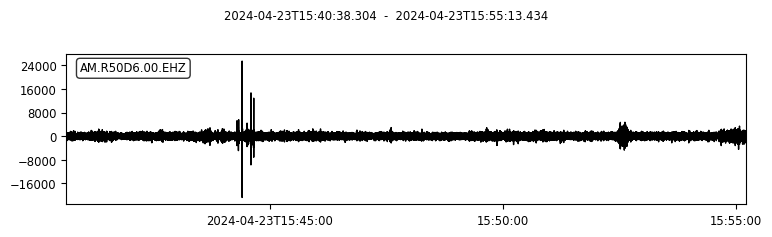

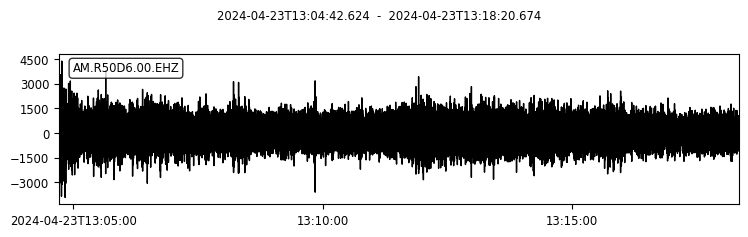

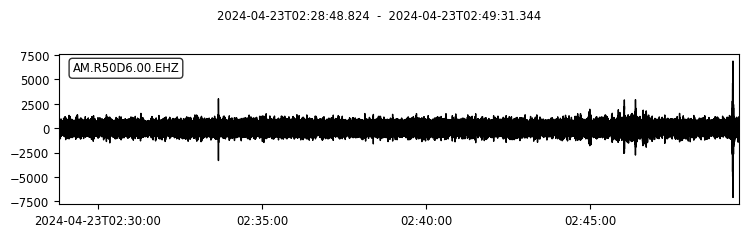

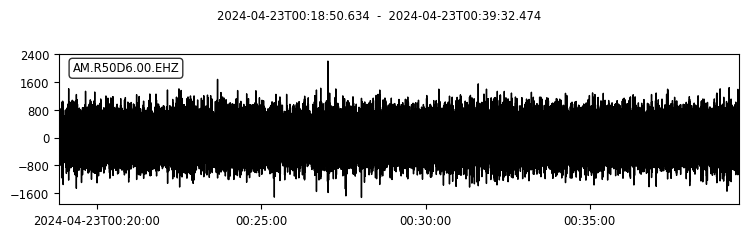

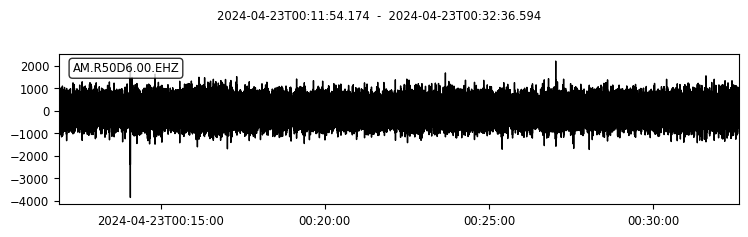

In [12]:
extracted_segments = extract_and_plot_waveforms(df, processed_stream)

for trace in extracted_segments:
    trace.plot()

**Identify Earthquakes Inside Stream Segments Using STA/ LTA**

In [14]:
sta_window = 2  # Short-time window in seconds
lta_window = 30.0  # Long-time window in seconds
threshold_on = 5  # STA/LTA threshold for triggering
threshold_off = 1  # STA/LTA threshold for turning off the trigger

detect_earthquakes(extracted_segments, sta_window, lta_window, threshold_on, threshold_off)

[(2024-04-23T15:44:24.504000Z, 2024-04-23T15:44:26.514000Z),
 (2024-04-23T15:52:31.054000Z, 2024-04-23T15:52:41.554000Z),
 (2024-04-23T02:49:19.694000Z, 2024-04-23T02:49:23.304000Z)]